<a href="https://colab.research.google.com/github/skyprince999/100-Days-Of-ML/blob/master/Day_22_fastai_tabular_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context

Traditionally we transfer categorical variables to one-hot encoding. The disadvantage is that this assumes independence among entities & creates a sparse matrix. This can lead to out-of-memory (OOM) while training. 

Entity embeddings instead use a vector to represent each entity. So each categorical variable is represented as a vector of floating points. Embeddings can does capture richer relationships & complexities. 


**Related paper**
(Entity Embeddings of Categorical Variables)[https://arxiv.org/abs/1604.06737] 
Rachal Thomas' blog on Fast.ai (Categorical Embeddings)[https://www.fast.ai/2018/04/29/categorical-embeddings/]

# Process flow

>> I am running this on CPU, but you can add a GPU for faster training (*around 3x speedup*)

1. Feature engineering is done for each store (store_id). Features are similar to this (notebook by kkiler)[https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50] 
2. `TabularList` is used to create a DataBunch for store_id = 1
3. Model is trained for a single store
4. Separate models are trained for each store (*Not shown here. Models are stored in a public dataset*)
5. Test data is processed
6. (Trained models)[https://www.kaggle.com/skylord/m5-forecasting-models] are used to then predict for each store in the test data



In [0]:
from  datetime import datetime, timedelta
import time
import gc
import numpy as np, pandas as pd
import gc

In [0]:
from fastai import *      # import * is considered as a bad coding practice! will have to change this!
from fastai.tabular import *

In [0]:
start_nb = time.time()

In [0]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

pd.options.display.max_columns = 50
h = 28 
max_lags = 70
tr_last = 1913
fday = datetime(2016,4, 25) 

# Define helper functions

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200, store_id = None):
    
    start = time.time()
    if store_id == None and is_train:
        print("ERROR: No store_id provided.Please provide an id [0-9]")
        return None
        
    prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv", dtype = PRICE_DTYPES)
    
    
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    # Filter out the values for store_id
    if is_train:
        prices = prices[prices['store_id'] == store_id]
        
    print(f"Shape of Store - {store_id} dataframe : ", prices.shape)
    
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    end = time.time()
    
    print("Processing time: ", (end-start))
    return dt

In [0]:
def create_fea(dt):
    start = time.time()
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
   
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
    
    # Drop NA values
    dt.dropna(inplace = True)     
    
    # Sort the dataframe on 'saledate' so we can easily create a validation set that data is in the 'future' of what's in the training set
    dt = dt.sort_values(by='date', ascending=False)
    dt = dt.reset_index(drop=True)
    end = time.time()
    print("Processing time: ", (end- start))
    
    return dt

In [0]:
import shutil

def checkDiskSpace():
    total, used, free = shutil.disk_usage("/")
    
    free = (free // (2**30))
    
    if free < 10:
        return -1
    else:
        return 0 
         

# print("Total: %d GiB" % (total // (2**30)))
# print("Used: %d GiB" % (used // (2**30)))
# print("Free: %d GiB" % (free // (2**30)))

# Pre-processing of train data

In [0]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
#train_cols = df.columns[~df.columns.isin(useless_cols)]

In [0]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [0]:
idx = 1
train_df = create_dt(is_train=True, first_day= FIRST_DAY, store_id = idx)
train_df = create_fea(train_df)
print(train_df.shape)
print(train_df['date'].min(), train_df['date'].max())

Shape of Store - 1 dataframe :  (637395, 4)
Processing time:  62.7872998714447
Processing time:  25.003514289855957
(4108081, 31)
2011-03-25 00:00:00 2016-04-24 00:00:00


In [0]:
# Sort by date (used for train/validation splits)
train_df.sort_values(by='date', inplace=True)

# convert sales value to log scale
train_df['sales'] = np.log(train_df['sales'] + 1)  # Taking logarithm values for sales


In [0]:

# Calculate where we should cut the validation set. We pick the most recent 'n' records in training set 
# where n is the number of entries in test set. 

cut = train_df['date'][(train_df['date'] == train_df['date'][62500])].index.max()
print(cut)
valid_idx = range(cut)


64020


In [0]:
# Define categorical, continous & dependent variables

cat_vars = ['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
           'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
           'snap_WI', 'week', 'quarter', 'mday']

cont_vars = ['lag_7', 'lag_28', 'rmean_7_7', 'rmean_28_7',
           'rmean_7_28', 'rmean_28_28', 'sell_price']

dep_var = 'sales'


In [0]:
# We want to limit the price range for our prediction to be within the history sale price range, so we need to calculate the y_range
# Note that we multiplied the maximum of 'SalePrice' by 1.2 so when we apply sigmoid, the upper limit will also be covered. 
max_y = np.max(train_df['sales'])*1.2
y_range = torch.tensor([0, max_y], device=defaults.device)
print(y_range)

tensor([0.0000, 6.5152])


# Model training

In [0]:

# Defining pre-processing we want for our fast.ai DataBunch
procs=[FillMissing, Categorify, Normalize]

# Use fast.ai datablock api to put our training data into the DataBunch, getting ready for training
data = (TabularList.from_df(train_df, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                       .split_by_idx(valid_idx)
                       .label_from_df(dep_var)
                       .databunch())


# Create our tabular learner. The dense layer is 1000 and 500 two layer NN. We used dropout, hai 
learn = tabular_learner(data, layers=[512,256, 128], ps=[0.05,0.01, 0.5], emb_drop=0.04, 
                            y_range=y_range, metrics=rmse)


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


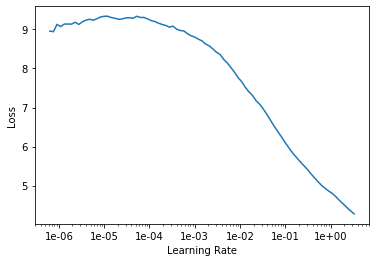

In [0]:
# Plot the learning rates
learn.recorder.plot()

In [0]:
# learn.fit_one_cycle(3, 1e-2, wd=0.2)
    
# print(f"Saving model...export_{idx}")
# learn.export(file = Path(f"/kaggle/working/export_{idx}.pkl")) # Save the model


In [0]:
learn = load_learner('/kaggle/input/m5-forecasting-models/', file=f'export_{idx}.pkl')

In [0]:
%%time
te = create_dt(False)
te = create_fea(te)

Shape of Store - None dataframe :  (6841121, 4)
Processing time:  11.380295515060425
Processing time:  104.87205600738525
CPU times: user 1min 54s, sys: 2.01 s, total: 1min 56s
Wall time: 1min 56s


In [0]:
print(te.shape)
te.head()

(487840, 31)


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,5.0,0.000000,2.428571,1.678571,1.964286,16,2,24
1,HOUSEHOLD_2_257_TX_1_validation,1352,3,4,1,1,d_1913,2.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,7.43,0.0,1.0,0.285714,1.000000,0.500000,0.607143,16,2,24
2,HOUSEHOLD_2_264_TX_1_validation,1359,3,4,1,1,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,7.98,0.0,0.0,0.142857,0.428571,0.321429,0.428571,16,2,24
3,HOUSEHOLD_2_263_TX_1_validation,1358,3,4,1,1,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.97,0.0,0.0,0.000000,0.428571,0.178571,0.214286,16,2,24
4,HOUSEHOLD_2_262_TX_1_validation,1357,3,4,1,1,d_1913,1.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,10.97,0.0,1.0,0.428571,0.285714,0.357143,0.392857,16,2,24


# Lets predict with a sample test row

In [0]:
learn.predict(te.loc[1])[1]

tensor([0.4182])

In [0]:
print("Raw prediction: ",learn.predict(te.loc[1]))
print("Taking exponentials: ",(np.exp(learn.predict(te.loc[1])[1]) -1) )


Raw prediction:  (FloatItem [0.418167], tensor([0.4182]), tensor([0.4182]))
Taking exponentials:  tensor([0.5192])


In [0]:
end_nb = time.time()

print("Notebook processing time: ", (end_nb- start_nb))

Notebook processing time:  241.76258730888367
